In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define target
df = pd.read_csv(r"C:\Users\nandi\Documents\ML_CO2_ER\data\df_merged.csv")
target = 'viscosity [Pa s]'
X = df.drop(columns=['solvent_ID', 'smiles', 'Binding_Energy_eV', 'solubility_CO2 [mol/L]', target])
y = df[target]

# Apply log transform
y_log = np.log1p(y)  # log1p handles small values safely

# Train-test split
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [2]:
from xgboost import XGBRegressor

model = XGBRegressor(
    tree_method='gpu_hist',
    device='cuda',
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=10,
    learning_rate=0.01,
    n_estimators=500,
    max_depth=6,
    random_state=42
)

model.fit(X_train_scaled, y_train_log)


c:\Users\nandi\Documents\ML_CO2_ER\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:06:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [3]:
y_pred_log = model.predict(X_test_scaled)

# Optional: Clip logs to avoid overflow
# clip_max = 20
# y_pred_log = np.clip(y_pred_log, a_min=None, a_max=clip_max)

# Inverse log1p
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

c:\Users\nandi\Documents\ML_CO2_ER\Lib\site-packages\xgboost\core.py:2676: UserWarning: [15:06:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
c:\Users\nandi\Documents\ML_CO2_ER\Lib\site-packages\xgboost\core.py:729: UserWarning: [15:06:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [4]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Fixed RMSE: {rmse:.4f}")
print(f"Fixed R²: {r2:.4f}")


Fixed RMSE: 0.0187
Fixed R²: 0.7453


In [5]:
feature_names = X.columns.tolist()  # This should match the model's input

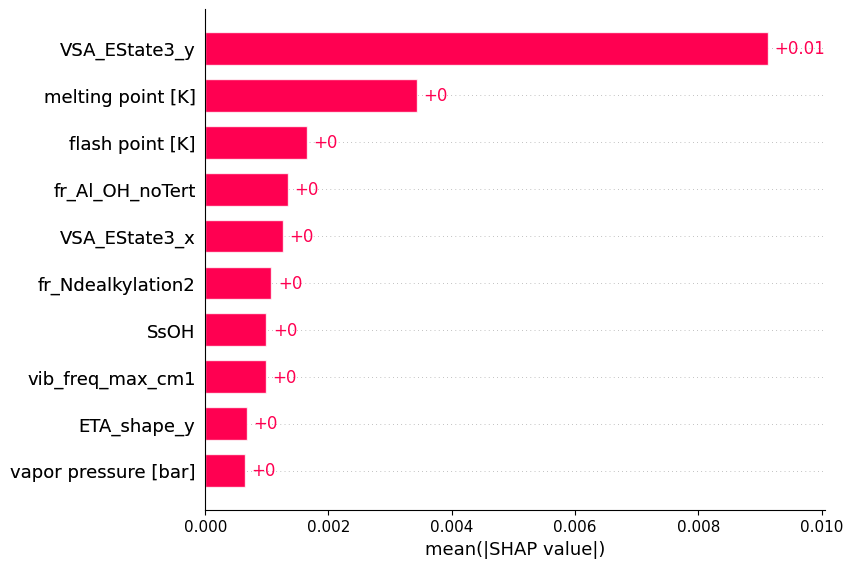

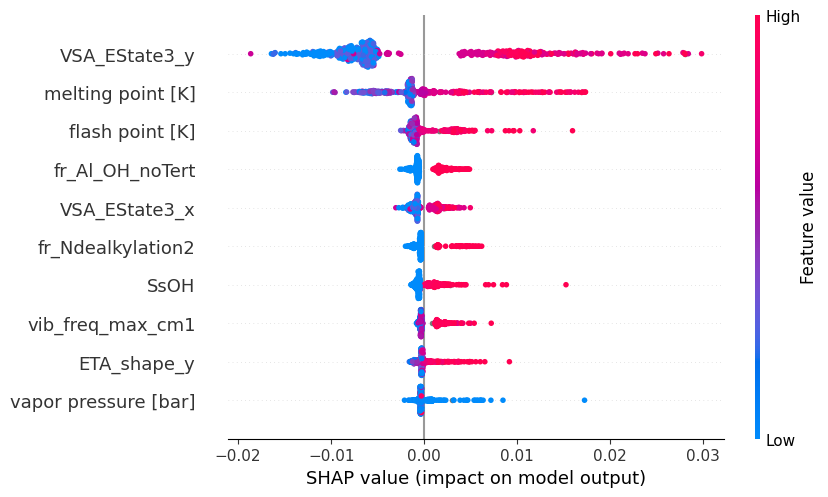

In [7]:
# Use scaled test set for SHAP input
import shap
explainer = shap.Explainer(model, feature_names=feature_names)
shap_values = explainer(X_test_scaled)

log_shap = shap_values.values
delta_viscosity = np.expm1(y_pred_log.reshape(-1, 1) + log_shap) - np.expm1(y_pred_log.reshape(-1, 1))

# # ----------- Step 4: Wrap new SHAP values in Explanation object -----------
# shap_values_original = shap.Explanation(
#     values=delta_viscosity,
#     base_values=np.expm1(shap_values.base_values),  # base values in original scale
#     data=X_test_scaled,
#     feature_names=X.columns
# )

# # ----------- Step 5: Plot SHAP bar plot in original scale -----------
# shap.plots.bar(shap_values_original, max_display=10)

mean_shap = np.abs(shap_values.values).mean(axis=0)
top_10_indices = np.argsort(mean_shap)[-10:][::-1]

# Slice SHAP explanation to include only top 10 features
shap_values_top10 = shap.Explanation(
    values=shap_values.values[:, top_10_indices],
    base_values=shap_values.base_values,
    data=shap_values.data[:, top_10_indices],
    feature_names=np.array(shap_values.feature_names)[top_10_indices].tolist()
)

# Plot only top 10 features
shap.plots.bar(shap_values_top10)
shap.plots.beeswarm(shap_values_top10)

In [8]:
# shap.plots.beeswarm(shap_values_original, max_display=10)

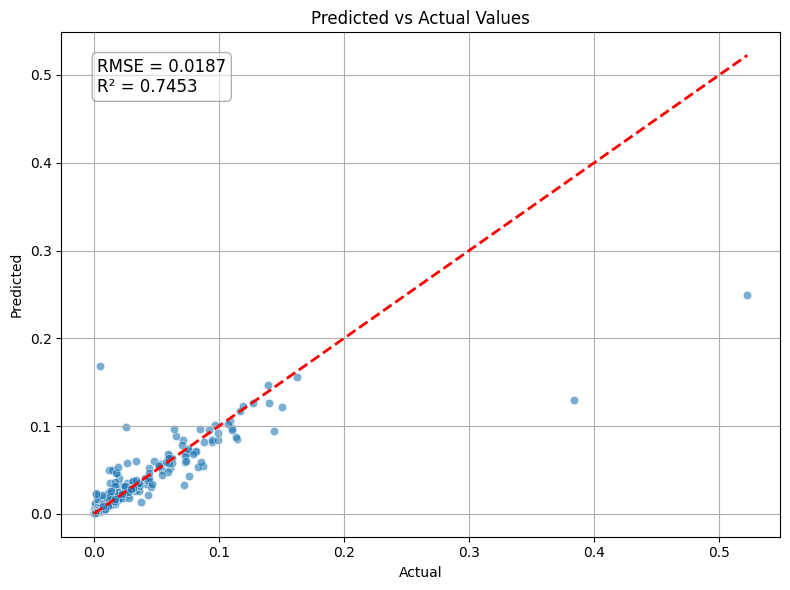

In [11]:
residuals = y_test - y_pred

import matplotlib.pyplot as plt
import seaborn as sns 

# --- A. Predicted vs Actual Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)

# Reference line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2)

# Annotate RMSE and R² inside the plot
plt.text(
    0.05, 0.95,
    f"RMSE = {rmse:.4f}\nR² = {r2:.4f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.6)
)

plt.title("Predicted vs Actual Values")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

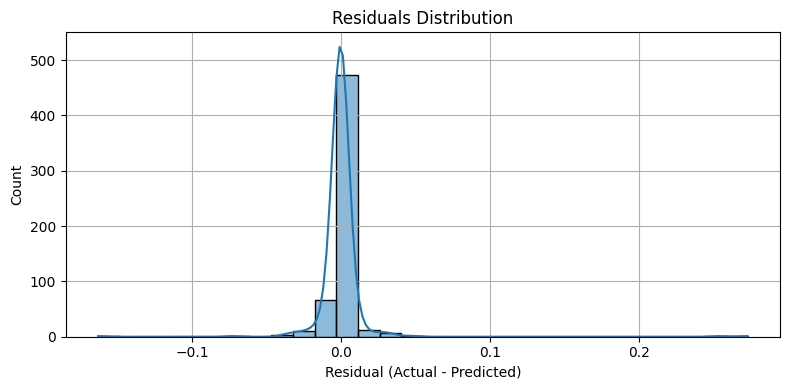

In [12]:
# --- B. Histogram of Residuals ---
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

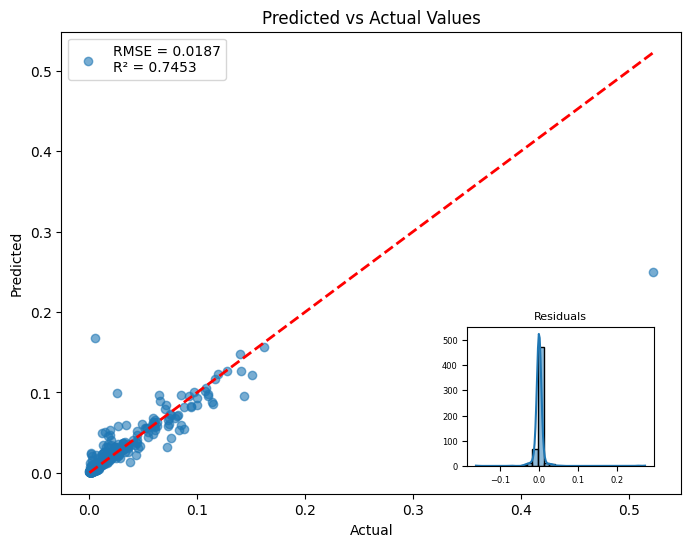

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, y_pred, alpha=0.6)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
ax.set_title("Predicted vs Actual Values")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.legend([f'RMSE = {rmse:.4f}\nR² = {r2:.4f}'], loc='upper left')

# Inset Plot: Residuals Distribution
inset_ax = inset_axes(ax, width="30%", height="30%", loc='lower right', borderpad=2)
sns.histplot(residuals, bins=30, kde=True, ax=inset_ax)
inset_ax.set_title("Residuals", fontsize=8)
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
inset_ax.tick_params(labelsize=6)